# Phase 1: Data Wrangling & EDA - TechNova Partners Turnover Analysis

**Objective**: Load, clean, and merge the three HR data sources to understand employee turnover patterns.

**Data Sources**:
1. **HRIS extract** (extrait_sirh.csv) - Employee demographics, role, salary, tenure
2. **Performance extract** (extrait_eval.csv) - Review scores, satisfaction ratings
3. **Well-being survey** (extrait_sondage.csv) - Survey responses with turnover flag

---

## 1. Environment Setup & Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Additional libraries for analysis
from pathlib import Path
import json
from scipy import stats

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment setup complete")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Environment setup complete
Pandas version: 2.3.1
Matplotlib version: 3.10.3


In [2]:
# Setup robust path handling and import utilities
import sys
from pathlib import Path

# Add project root to Python path and setup environment
# This works regardless of where the notebook is run from
current_dir = Path.cwd()
project_root = current_dir
while project_root != project_root.parent:
    if (project_root / 'pyproject.toml').exists() or (project_root / 'hr_analytics_utils.py').exists():
        break
    project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Import and setup
from hr_analytics_utils import setup_notebook_environment, load_raw_data_files

# Setup environment and load data
env_info = setup_notebook_environment()
df_sirh, df_eval, df_sondage = load_raw_data_files()

print(f"HRIS data loaded: {df_sirh.shape[0]} rows, {df_sirh.shape[1]} columns")
print(f"Performance data loaded: {df_eval.shape[0]} rows, {df_eval.shape[1]} columns")
print(f"Survey data loaded: {df_sondage.shape[0]} rows, {df_sondage.shape[1]} columns")

Project root already in Python path: /workspaces/Automated-classification
NOTEBOOK ENVIRONMENT SETUP
Project root: /workspaces/Automated-classification
Results directory: /workspaces/Automated-classification/results
Database path: /workspaces/Automated-classification/results/technova_hr.db
Python path includes project: True

Data files status:
   OK extrait_sirh.csv: /workspaces/Automated-classification/extrait_sirh.csv
   OK extrait_eval.csv: /workspaces/Automated-classification/extrait_eval.csv
   OK extrait_sondage.csv: /workspaces/Automated-classification/extrait_sondage.csv

Database status: OK /workspaces/Automated-classification/results/technova_hr.db

Environment setup complete!

Loading raw data files...
HRIS data loaded: 1470 rows, 12 columns
Performance data loaded: 1470 rows, 10 columns
Survey data loaded: 1470 rows, 12 columns
HRIS data loaded: 1470 rows, 12 columns
Performance data loaded: 1470 rows, 10 columns
Survey data loaded: 1470 rows, 12 columns


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 2. Data Inspection & Quality Assessment

In [3]:
# Examine the structure of each dataset
print("HRIS Data Structure:")
print("=" * 20)
print(df_sirh.info())
print("\nFirst few rows:")
print(df_sirh.head())

HRIS Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memo

In [4]:
print("Performance Data Structure:")
print("=" * 27)
print(df_eval.info())
print("\nFirst few rows:")
print(df_eval.head())

Performance Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64

In [5]:
print("Survey Data Structure:")
print("=" * 21)
print(df_sondage.info())
print("\nFirst few rows:")
print(df_sondage.head())

Survey Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsab

## 3. Data Cleaning & Preprocessing

In [6]:
# Check for missing values and data quality issues
def check_data_quality(df, name):
    print(f" Data Quality Report for {name}:")
    print("=" * 50)
    print(f"Shape: {df.shape}")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Duplicates: {df.duplicated().sum()}")
    print(f"Data types:\n{df.dtypes}")
    print("\n")

# Check all datasets
check_data_quality(df_sirh, "HRIS")
check_data_quality(df_eval, "Performance")
check_data_quality(df_sondage, "Survey")

 Data Quality Report for HRIS:
Shape: (1470, 12)
Missing values:
id_employee                       0
age                               0
genre                             0
revenu_mensuel                    0
statut_marital                    0
departement                       0
poste                             0
nombre_experiences_precedentes    0
nombre_heures_travailless         0
annee_experience_totale           0
annees_dans_l_entreprise          0
annees_dans_le_poste_actuel       0
dtype: int64
Duplicates: 0
Data types:
id_employee                        int64
age                                int64
genre                             object
revenu_mensuel                     int64
statut_marital                    object
departement                       object
poste                             object
nombre_experiences_precedentes     int64
nombre_heures_travailless          int64
annee_experience_totale            int64
annees_dans_l_entreprise           int64
annees_dans_l

In [7]:
# Identify joining keys and understand data relationships
print("Identifying join keys:")
print("=" * 30)

# Check if datasets have common identifiers
print("HRIS columns:", df_sirh.columns.tolist())
print("Performance columns:", df_eval.columns.tolist())
print("Survey columns:", df_sondage.columns.tolist())

# Check for potential linking columns
print("\nChecking for employee ID patterns:")
if 'id_employee' in df_sirh.columns:
    print(f"HRIS employee IDs: {df_sirh['id_employee'].nunique()} unique values")
    print(f"HRIS ID range: {df_sirh['id_employee'].min()} to {df_sirh['id_employee'].max()}")

if 'eval_number' in df_eval.columns:
    print(f"Performance eval numbers: {df_eval['eval_number'].nunique()} unique values")
    print(f"Performance eval samples: {df_eval['eval_number'].head().tolist()}")

if 'code_sondage' in df_sondage.columns:
    print(f"Survey codes: {df_sondage['code_sondage'].nunique()} unique values")
    print(f"Survey code samples: {df_sondage['code_sondage'].head().tolist()}")

Identifying join keys:
HRIS columns: ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel']
Performance columns: ['satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente']
Survey columns: ['a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']

Checking for employee ID patterns:
HRIS employee I

In [8]:
# Create a merge strategy based on row order (assuming aligned datasets)
print("Creating merge strategy:")
print("=" * 30)

# Check if all datasets have the same number of rows
if len(df_sirh) == len(df_eval) == len(df_sondage):
    print(f"All datasets have {len(df_sirh)} rows - proceeding with index-based merge")
    
    # Create a unified employee ID for tracking
    df_sirh['employee_id'] = df_sirh['id_employee']
    df_eval['employee_id'] = df_sirh['id_employee']  # Use HRIS IDs
    df_sondage['employee_id'] = df_sirh['id_employee']  # Use HRIS IDs
    
    # Merge datasets
    df_merged = pd.concat([
        df_sirh.reset_index(drop=True),
        df_eval.reset_index(drop=True),
        df_sondage.reset_index(drop=True)
    ], axis=1)
    
    # Remove duplicate employee_id columns
    df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
    
    print(f"Merged dataset created: {df_merged.shape}")
    print(f"Columns: {df_merged.columns.tolist()}")
    
else:
    print("Datasets have different lengths - need alternative merge strategy")
    print(f"HRIS: {len(df_sirh)}, Performance: {len(df_eval)}, Survey: {len(df_sondage)}")

Creating merge strategy:
All datasets have 1470 rows - proceeding with index-based merge
Merged dataset created: (1470, 35)
Columns: ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'employee_id', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_

In [9]:
# Clean the merged dataset
print("Cleaning merged dataset:")
print("=" * 30)

# Check the merged dataset
print(f"Original shape: {df_merged.shape}")
print(f"Missing values:\n{df_merged.isnull().sum().sort_values(ascending=False).head(10)}")

# Clean specific columns
# 1. Convert target variable to binary
df_merged['target_turnover'] = (df_merged['a_quitte_l_entreprise'] == 'Oui').astype(int)

# 2. Clean salary increase column
if 'augementation_salaire_precedente' in df_merged.columns:
    df_merged['salary_increase_pct'] = df_merged['augementation_salaire_precedente'].str.replace('%', '').str.replace(' ', '').astype(float)

# 3. Clean binary columns
binary_mappings = {
    'heure_supplementaires': {'Oui': 1, 'Non': 0},
    'ayant_enfants': {'Y': 1, 'N': 0}
}

for col, mapping in binary_mappings.items():
    if col in df_merged.columns:
        df_merged[col + '_binary'] = df_merged[col].map(mapping)

print(f"\nCleaned dataset shape: {df_merged.shape}")
print(f"Target variable distribution:\n{df_merged['target_turnover'].value_counts()}")

Cleaning merged dataset:
Original shape: (1470, 35)
Missing values:
id_employee                       0
age                               0
genre                             0
revenu_mensuel                    0
statut_marital                    0
departement                       0
poste                             0
nombre_experiences_precedentes    0
nombre_heures_travailless         0
annee_experience_totale           0
dtype: int64

Cleaned dataset shape: (1470, 39)
Target variable distribution:
target_turnover
0    1233
1     237
Name: count, dtype: int64


## 4. Exploratory Data Analysis

In [10]:
# Basic statistics and distributions
print(" Key Statistics:")
print("=" * 30)

# Overall turnover rate
turnover_rate = df_merged['target_turnover'].mean()
print(f"Overall turnover rate: {turnover_rate:.2%}")

# Key demographic statistics
print(f"\nDemographics:")
print(f"Average age: {df_merged['age'].mean():.1f} years")
print(f"Average tenure: {df_merged['annees_dans_l_entreprise'].mean():.1f} years")
print(f"Average salary: {df_merged['revenu_mensuel'].mean():.0f} €")

# Department distribution
print(f"\nDepartment distribution:")
print(df_merged['departement'].value_counts())

# Position distribution
print(f"\nPosition distribution:")
print(df_merged['poste'].value_counts())

 Key Statistics:
Overall turnover rate: 16.12%

Demographics:
Average age: 36.9 years
Average tenure: 7.0 years
Average salary: 6503 €

Department distribution:
departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64

Position distribution:
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64


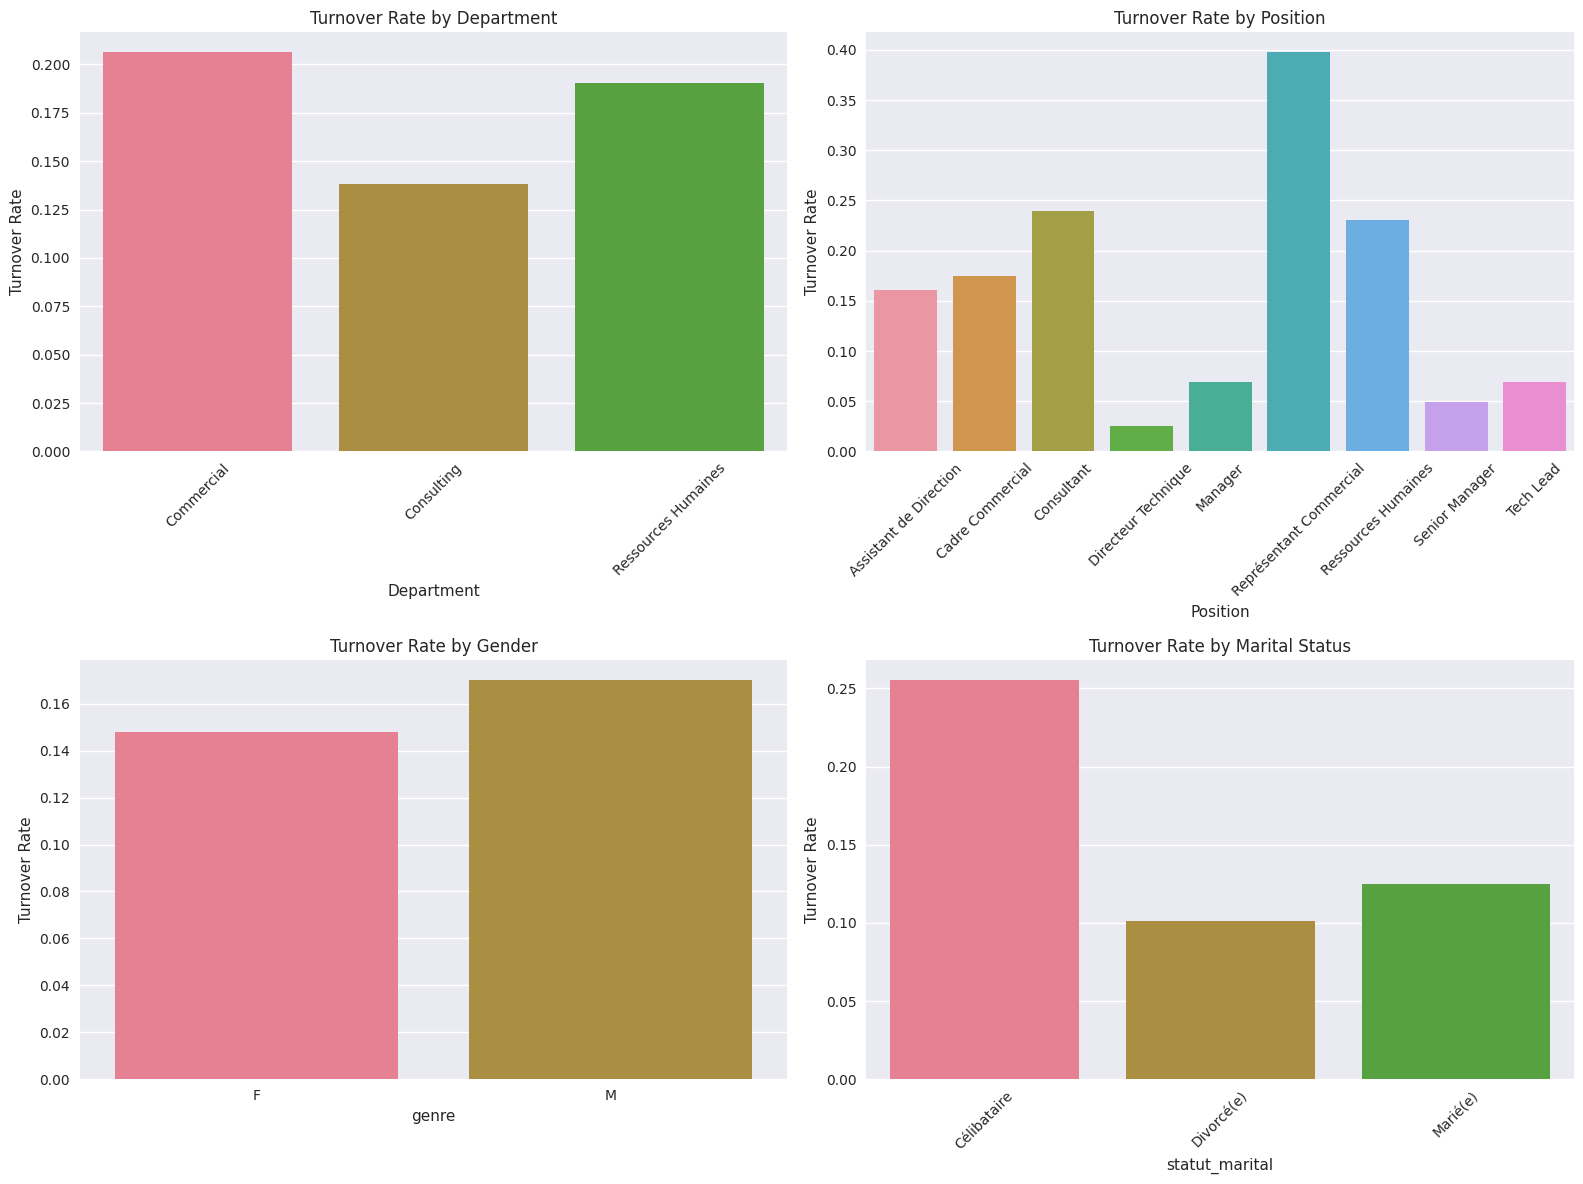

In [11]:
# Analyze turnover by key demographics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Turnover by Department
dept_turnover = df_merged.groupby('departement')['target_turnover'].agg(['mean', 'count']).reset_index()
dept_turnover.columns = ['Department', 'Turnover_Rate', 'Count']
sns.barplot(data=dept_turnover, x='Department', y='Turnover_Rate', ax=axes[0,0])
axes[0,0].set_title('Turnover Rate by Department')
axes[0,0].set_ylabel('Turnover Rate')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Turnover by Position
pos_turnover = df_merged.groupby('poste')['target_turnover'].agg(['mean', 'count']).reset_index()
pos_turnover.columns = ['Position', 'Turnover_Rate', 'Count']
sns.barplot(data=pos_turnover, x='Position', y='Turnover_Rate', ax=axes[0,1])
axes[0,1].set_title('Turnover Rate by Position')
axes[0,1].set_ylabel('Turnover Rate')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Turnover by Gender
gender_turnover = df_merged.groupby('genre')['target_turnover'].mean().reset_index()
sns.barplot(data=gender_turnover, x='genre', y='target_turnover', ax=axes[1,0])
axes[1,0].set_title('Turnover Rate by Gender')
axes[1,0].set_ylabel('Turnover Rate')

# 4. Turnover by Marital Status
marital_turnover = df_merged.groupby('statut_marital')['target_turnover'].mean().reset_index()
sns.barplot(data=marital_turnover, x='statut_marital', y='target_turnover', ax=axes[1,1])
axes[1,1].set_title('Turnover Rate by Marital Status')
axes[1,1].set_ylabel('Turnover Rate')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

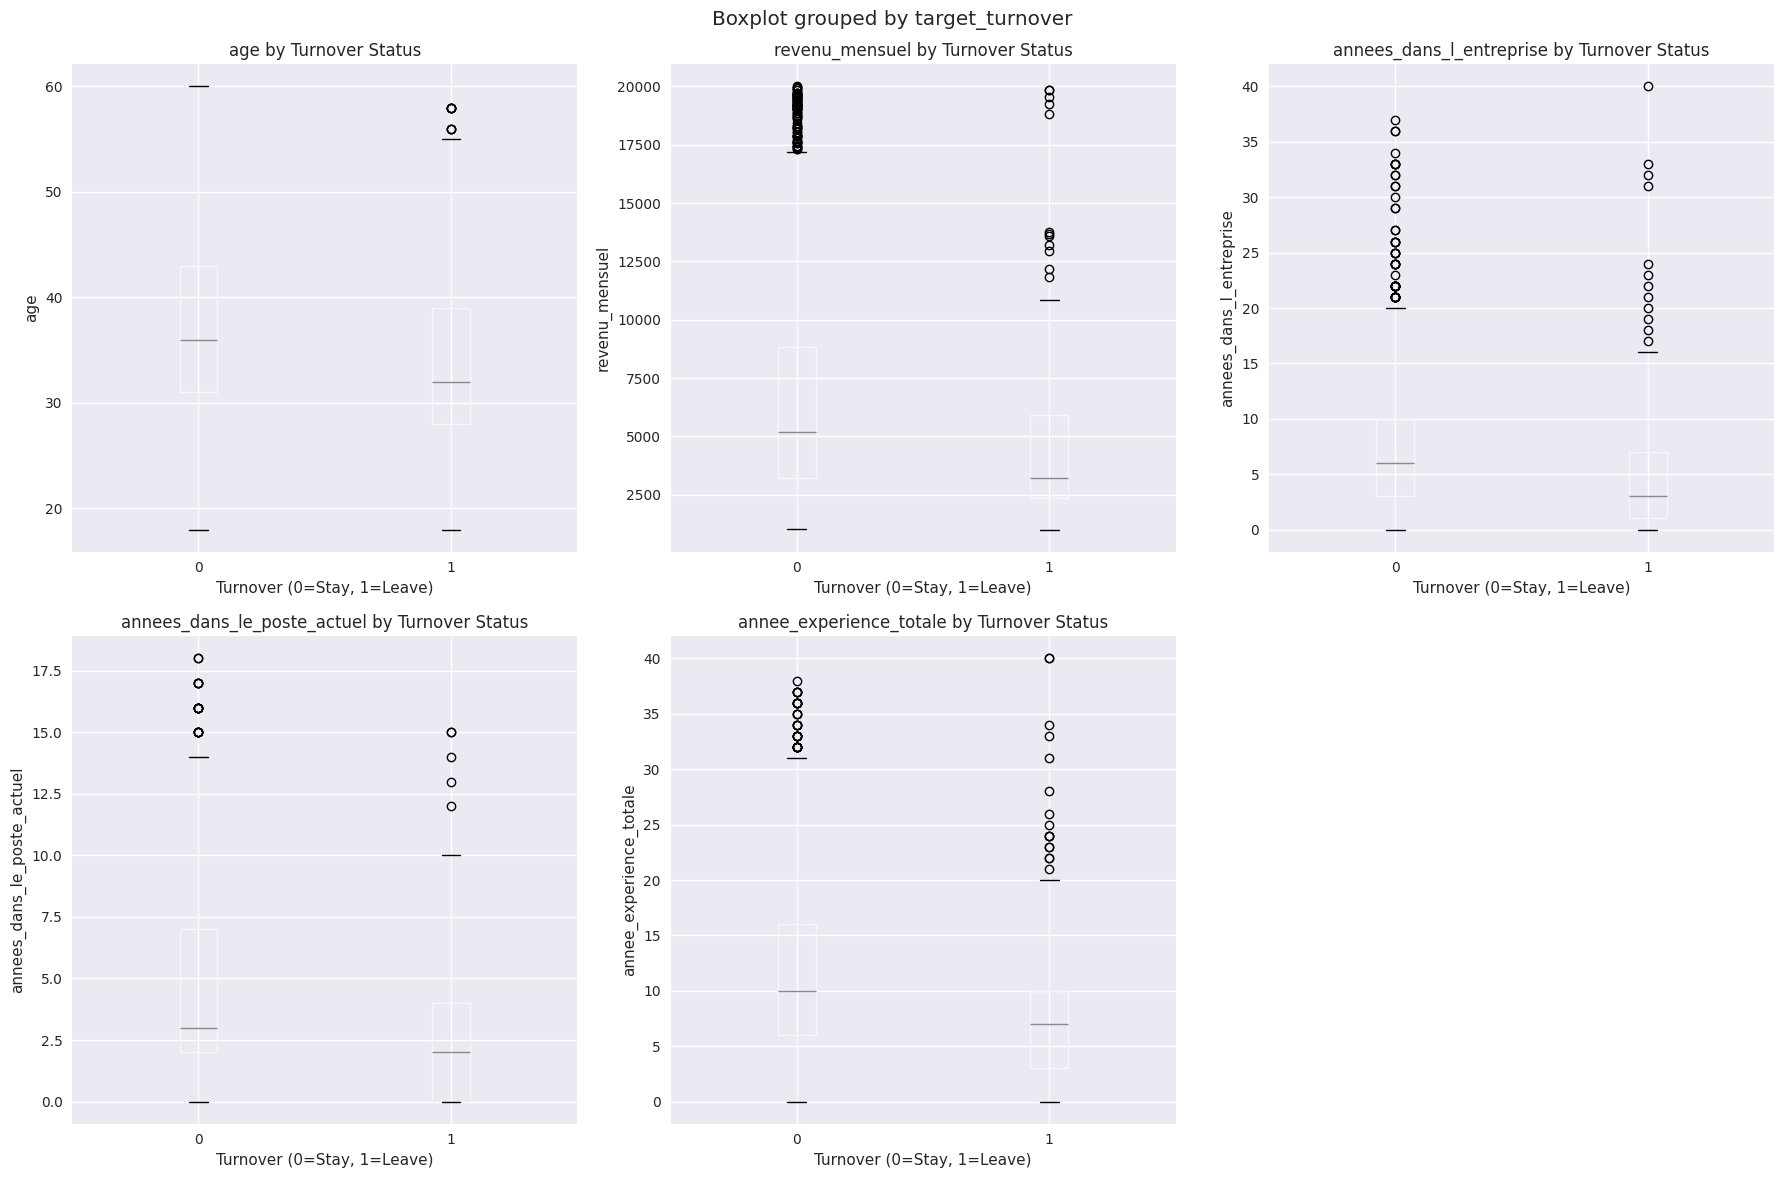


Statistical Tests (Leavers vs Stayers):
age:
  Leavers mean: 33.61
  Stayers mean: 37.56
  P-value: 0.0000 ***

revenu_mensuel:
  Leavers mean: 4787.09
  Stayers mean: 6832.74
  P-value: 0.0000 ***

annees_dans_l_entreprise:
  Leavers mean: 5.13
  Stayers mean: 7.37
  P-value: 0.0000 ***

annees_dans_le_poste_actuel:
  Leavers mean: 2.90
  Stayers mean: 4.48
  P-value: 0.0000 ***

annee_experience_totale:
  Leavers mean: 8.24
  Stayers mean: 11.86
  P-value: 0.0000 ***



In [12]:
# Analyze numerical variables
numerical_cols = ['age', 'revenu_mensuel', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'annee_experience_totale']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    # Create box plots comparing leavers vs stayers
    df_merged.boxplot(column=col, by='target_turnover', ax=axes[i])
    axes[i].set_title(f'{col} by Turnover Status')
    axes[i].set_xlabel('Turnover (0=Stay, 1=Leave)')
    axes[i].set_ylabel(col)

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Statistical tests for numerical variables
print("\nStatistical Tests (Leavers vs Stayers):")
print("=" * 50)

leavers = df_merged[df_merged['target_turnover'] == 1]
stayers = df_merged[df_merged['target_turnover'] == 0]

for col in numerical_cols:
    if col in df_merged.columns:
        stat, p_value = stats.ttest_ind(leavers[col].dropna(), stayers[col].dropna())
        leaver_mean = leavers[col].mean()
        stayer_mean = stayers[col].mean()
        print(f"{col}:")
        print(f"  Leavers mean: {leaver_mean:.2f}")
        print(f"  Stayers mean: {stayer_mean:.2f}")
        print(f"  P-value: {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")
        print()

Satisfaction & Performance Analysis:
Satisfaction columns found: ['satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso']


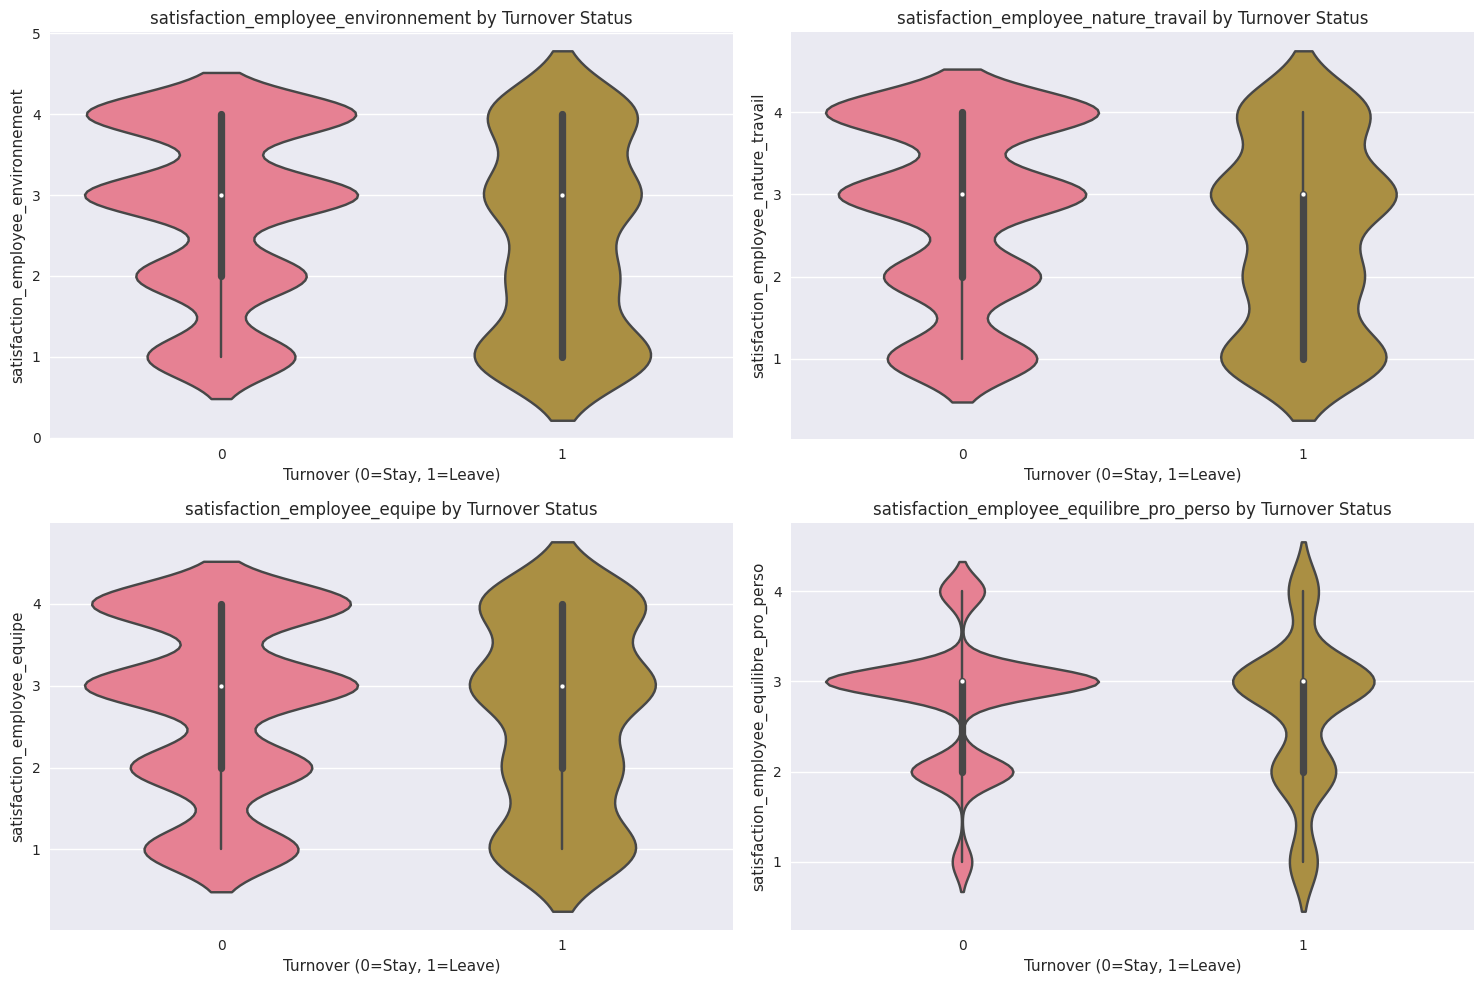


Satisfaction Score Analysis:
satisfaction_employee_environnement: Leavers=2.46, Stayers=2.77, p=0.0001
satisfaction_employee_nature_travail: Leavers=2.47, Stayers=2.78, p=0.0001
satisfaction_employee_equipe: Leavers=2.60, Stayers=2.73, p=0.0787
satisfaction_employee_equilibre_pro_perso: Leavers=2.66, Stayers=2.78, p=0.0142

Performance columns found: ['note_evaluation_precedente', 'note_evaluation_actuelle']
note_evaluation_precedente: Leavers=2.52, Stayers=2.77, p=0.0000
note_evaluation_actuelle: Leavers=3.16, Stayers=3.15, p=0.9119


In [13]:
# Analyze satisfaction scores
satisfaction_cols = [col for col in df_merged.columns if 'satisfaction' in col.lower()]
evaluation_cols = [col for col in df_merged.columns if 'note_evaluation' in col or 'evaluation' in col.lower()]

print("Satisfaction & Performance Analysis:")
print("=" * 40)

# Satisfaction scores
if satisfaction_cols:
    print("Satisfaction columns found:", satisfaction_cols)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(satisfaction_cols[:4]):
        if col in df_merged.columns:
            # Create violin plots
            sns.violinplot(data=df_merged, x='target_turnover', y=col, ax=axes[i])
            axes[i].set_title(f'{col} by Turnover Status')
            axes[i].set_xlabel('Turnover (0=Stay, 1=Leave)')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print("\nSatisfaction Score Analysis:")
    for col in satisfaction_cols:
        if col in df_merged.columns:
            leaver_mean = leavers[col].mean()
            stayer_mean = stayers[col].mean()
            stat, p_value = stats.ttest_ind(leavers[col].dropna(), stayers[col].dropna())
            print(f"{col}: Leavers={leaver_mean:.2f}, Stayers={stayer_mean:.2f}, p={p_value:.4f}")

# Performance scores
if evaluation_cols:
    print("\nPerformance columns found:", evaluation_cols)
    
    for col in evaluation_cols:
        if col in df_merged.columns:
            leaver_mean = leavers[col].mean()
            stayer_mean = stayers[col].mean()
            stat, p_value = stats.ttest_ind(leavers[col].dropna(), stayers[col].dropna())
            print(f"{col}: Leavers={leaver_mean:.2f}, Stayers={stayer_mean:.2f}, p={p_value:.4f}")

Correlation Analysis:
Analyzing correlations for 21 numerical variables


Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


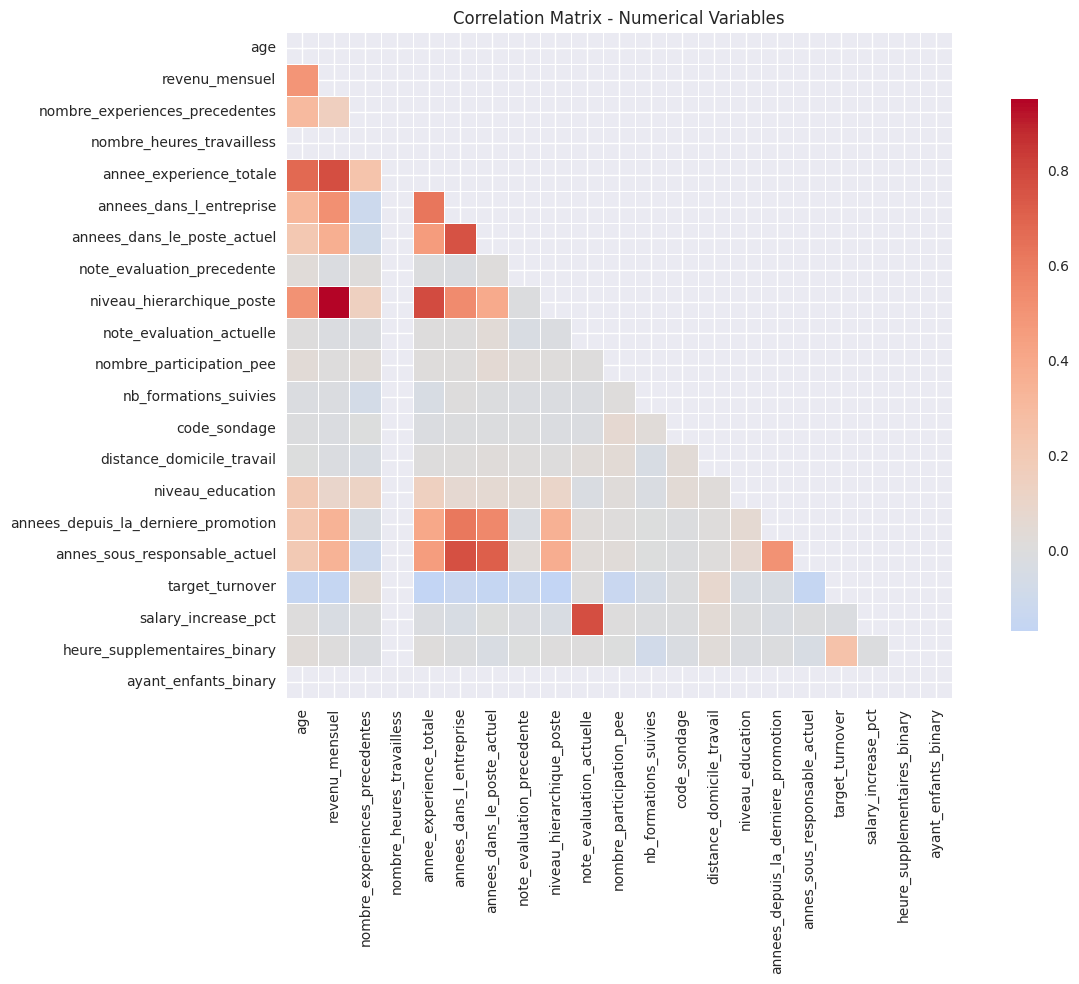


Correlations with Turnover:
target_turnover                  1.000000
heure_supplementaires_binary     0.246118
annee_experience_totale         -0.171063
niveau_hierarchique_poste       -0.169105
annees_dans_le_poste_actuel     -0.160545
revenu_mensuel                  -0.159840
age                             -0.159205
annes_sous_responsable_actuel   -0.156199
nombre_participation_pee        -0.137145
annees_dans_l_entreprise        -0.134392
Name: target_turnover, dtype: float64


In [14]:
# Correlation analysis
print("Correlation Analysis:")
print("=" * 25)

# Select numerical columns for correlation
numerical_columns = df_merged.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns
numerical_columns = [col for col in numerical_columns if 'id' not in col.lower() and 'employee' not in col.lower()]

print(f"Analyzing correlations for {len(numerical_columns)} numerical variables")

# Calculate correlation matrix
correlation_matrix = df_merged[numerical_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Variables')
plt.tight_layout()
plt.show()

# Focus on correlations with turnover
turnover_correlations = correlation_matrix['target_turnover'].sort_values(key=abs, ascending=False)
print("\nCorrelations with Turnover:")
print(turnover_correlations.head(10))

Advanced Visualizations:


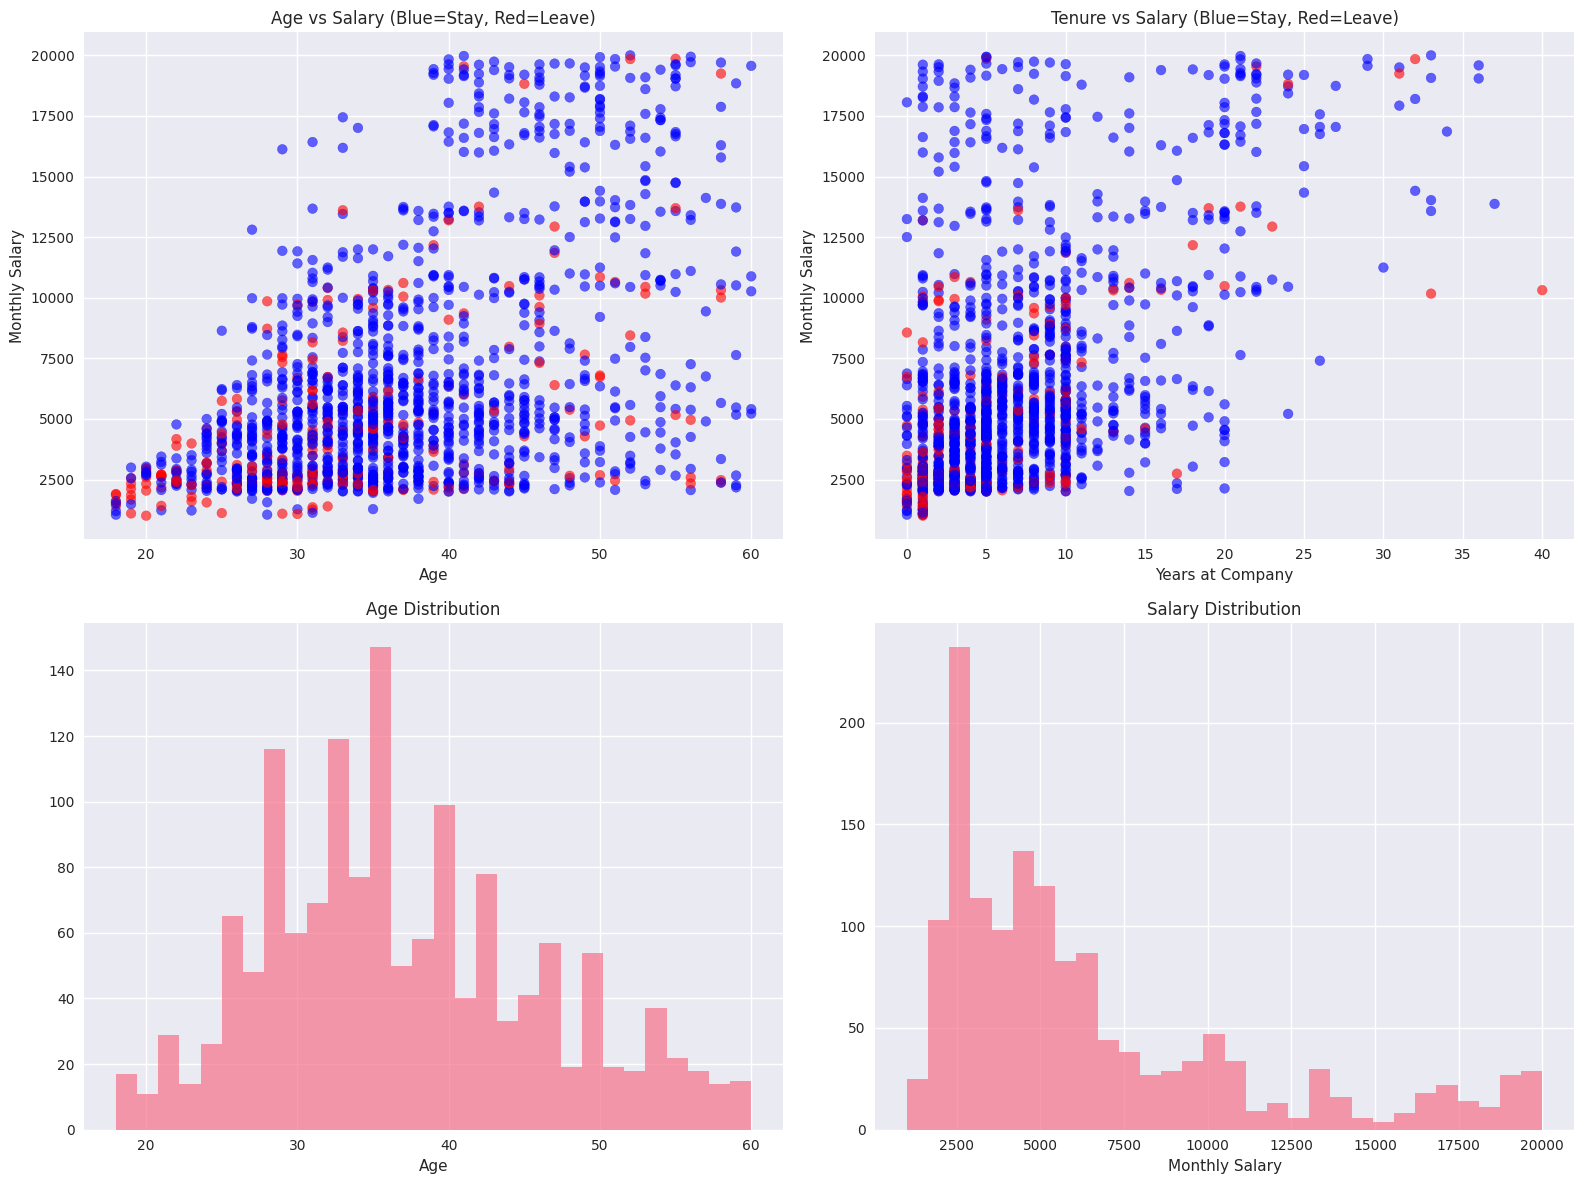

In [15]:
# Advanced visualizations
print("Advanced Visualizations:")
print("=" * 30)

# 1. Age vs Salary colored by turnover
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age vs Salary scatter plot
colors = ['blue' if x == 0 else 'red' for x in df_merged['target_turnover']]
axes[0,0].scatter(df_merged['age'], df_merged['revenu_mensuel'], c=colors, alpha=0.6)
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Monthly Salary')
axes[0,0].set_title('Age vs Salary (Blue=Stay, Red=Leave)')

# Tenure vs Salary
axes[0,1].scatter(df_merged['annees_dans_l_entreprise'], df_merged['revenu_mensuel'], c=colors, alpha=0.6)
axes[0,1].set_xlabel('Years at Company')
axes[0,1].set_ylabel('Monthly Salary')
axes[0,1].set_title('Tenure vs Salary (Blue=Stay, Red=Leave)')

# Distribution of key variables
df_merged['age'].hist(bins=30, alpha=0.7, ax=axes[1,0])
axes[1,0].set_xlabel('Age')
axes[1,0].set_title('Age Distribution')

df_merged['revenu_mensuel'].hist(bins=30, alpha=0.7, ax=axes[1,1])
axes[1,1].set_xlabel('Monthly Salary')
axes[1,1].set_title('Salary Distribution')

plt.tight_layout()
plt.show()

## 5. Key Insights Summary

In [16]:
# Generate key insights
print("KEY INSIGHTS FROM EDA:")
print("=" * 40)

# 1. Overall turnover rate
turnover_rate = df_merged['target_turnover'].mean()
print(f"1. OVERALL TURNOVER RATE: {turnover_rate:.2%}")

# 2. Demographic insights
print("\n2. DEMOGRAPHIC PATTERNS:")
dept_analysis = df_merged.groupby('departement')['target_turnover'].agg(['mean', 'count'])
highest_turnover_dept = dept_analysis['mean'].idxmax()
print(f"   - Highest turnover department: {highest_turnover_dept} ({dept_analysis.loc[highest_turnover_dept, 'mean']:.2%})")

# 3. Salary insights
print("\n3. COMPENSATION PATTERNS:")
leaver_salary = df_merged[df_merged['target_turnover'] == 1]['revenu_mensuel'].mean()
stayer_salary = df_merged[df_merged['target_turnover'] == 0]['revenu_mensuel'].mean()
print(f"   - Average salary - Leavers: €{leaver_salary:.0f}, Stayers: €{stayer_salary:.0f}")
print(f"   - Salary difference: €{abs(leaver_salary - stayer_salary):.0f}")

# 4. Tenure insights
print("\n4. TENURE PATTERNS:")
leaver_tenure = df_merged[df_merged['target_turnover'] == 1]['annees_dans_l_entreprise'].mean()
stayer_tenure = df_merged[df_merged['target_turnover'] == 0]['annees_dans_l_entreprise'].mean()
print(f"   - Average tenure - Leavers: {leaver_tenure:.1f} years, Stayers: {stayer_tenure:.1f} years")

# 5. Satisfaction insights
satisfaction_cols = [col for col in df_merged.columns if 'satisfaction' in col.lower()]
if satisfaction_cols:
    print("\n5. SATISFACTION PATTERNS:")
    for col in satisfaction_cols[:3]:  # Show top 3
        leaver_sat = df_merged[df_merged['target_turnover'] == 1][col].mean()
        stayer_sat = df_merged[df_merged['target_turnover'] == 0][col].mean()
        print(f"   - {col}: Leavers {leaver_sat:.2f}, Stayers {stayer_sat:.2f}")

# 6. Data quality summary
print("\n6. DATA QUALITY:")
print(f"   - Total records: {len(df_merged)}")
print(f"   - Missing values: {df_merged.isnull().sum().sum()}")
print(f"   - Duplicates: {df_merged.duplicated().sum()}")

print("\nEDA COMPLETE - Ready for feature engineering phase")

KEY INSIGHTS FROM EDA:
1. OVERALL TURNOVER RATE: 16.12%

2. DEMOGRAPHIC PATTERNS:
   - Highest turnover department: Commercial (20.63%)

3. COMPENSATION PATTERNS:
   - Average salary - Leavers: €4787, Stayers: €6833
   - Salary difference: €2046

4. TENURE PATTERNS:
   - Average tenure - Leavers: 5.1 years, Stayers: 7.4 years

5. SATISFACTION PATTERNS:
   - satisfaction_employee_environnement: Leavers 2.46, Stayers 2.77
   - satisfaction_employee_nature_travail: Leavers 2.47, Stayers 2.78
   - satisfaction_employee_equipe: Leavers 2.60, Stayers 2.73

6. DATA QUALITY:
   - Total records: 1470
   - Missing values: 0
   - Duplicates: 0

EDA COMPLETE - Ready for feature engineering phase


In [17]:
# Save to SQLite for SQLAlchemy practice
from sqlalchemy import create_engine
output_path = Path('../results')

engine = create_engine('sqlite:///' + str(output_path / 'technova_hr.db'))
df_merged.to_sql('employee_data', engine, index=False, if_exists='replace')

print(f"Data saved to:")
print(f"   - SQLite: {output_path / 'technova_hr.db'}")
print(f"   - Shape: {df_merged.shape}")
print(f"   - Columns: {len(df_merged.columns)}")

Data saved to:
   - SQLite: ../results/technova_hr.db
   - Shape: (1470, 39)
   - Columns: 39
